In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fake-news/test.csv
/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.50d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt
/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt


In [2]:
train_df = pd.read_csv('/kaggle/input/fake-news/train.csv')

In [3]:
len(train_df)

20800

In [4]:
valid = train_df[15000:]

In [5]:
df_trn = pd.DataFrame({'text':train_df['title'].values, 'labels':train_df['label'].values})
df_val = pd.DataFrame({'text':valid['title'].values, 'labels':valid['label'].values})

In [6]:
df_trn = df_trn.sample(frac=1)
df_val = df_val.sample(frac=1)

In [127]:
positive_counts = len(df_val[df_val['labels']==0])
negative_counts = len(df_val[df_val['labels']==1])

In [128]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",'i\'m':'i am', "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled'}

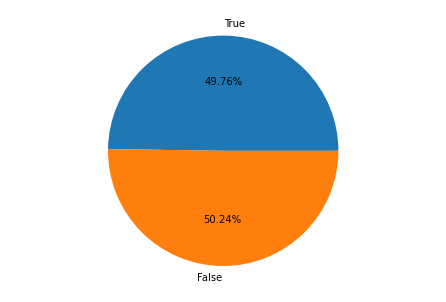

In [129]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
labels = ['True', 'False']
nums = [positive_counts,negative_counts]
ax.pie(nums, labels = labels,autopct='%1.2f%%')
plt.show()

In [10]:
from wordcloud import WordCloud,STOPWORDS
stopwords = set(STOPWORDS)

true_news = df_trn[df_trn['labels']==0]
false_news = df_trn[df_trn['labels']==1]

true_text = true_news['text'].values
false_text = false_news['text'].values

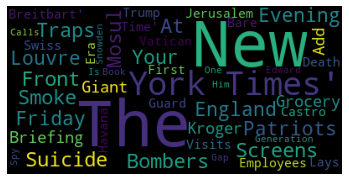

In [11]:
wordcloud = WordCloud().generate(str(true_text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

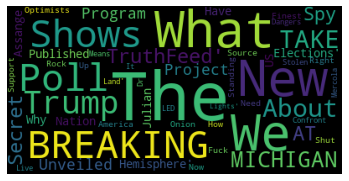

In [12]:
wordcloud = WordCloud().generate(str(false_text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data import Field,BucketIterator,TabularDataset
import torchtext
import spacy
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def clean_contractions(text, mapping):
    text = text.lower()
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else mapping[t.lower()] if t.lower() in mapping else t for t in text.split(" ")])
    return text

In [15]:
def remove_newlines(sent):
    sent = re.sub(r'\s+', " ", sent )
    return sent

In [16]:
df_trn['text'] = df_trn['text'].apply(lambda x: clean_contractions(str(x),contraction_mapping))
df_val['text'] = df_val['text'].apply(lambda x: clean_contractions(str(x),contraction_mapping))

df_trn['text'] = df_trn['text'].apply(lambda x: remove_newlines(str(x)))
df_val['text'] = df_val['text'].apply(lambda x: remove_newlines(str(x)))

In [17]:
df_trn.to_csv('train.csv',index = False)
df_val.to_csv('validation.csv',index = False)

In [18]:
from torchtext import data

tokenizer = lambda s: s.lower().split()

text1 = data.Field(tokenize=tokenizer,
                  batch_first=True,
                  include_lengths=True,
                  )

label = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)

In [19]:
fields = [('text',text1),('labels',label)]

In [20]:
train_data, valid_data = data.TabularDataset.splits(
    path='/kaggle/working/',
    train='train.csv',
    validation = 'validation.csv',
    format='csv',
    fields=fields,
    skip_header=True
)

In [21]:
text1.build_vocab(train_data,valid_data)

In [22]:
label.build_vocab(train_data,valid_data)

In [23]:
!cp ../input/glove-global-vectors-for-word-representation/glove.6B.100d.txt /kaggle/working 

In [24]:
from torchtext import vocab

embeddings = vocab.Vectors('glove.6B.100d.txt','/kaggle/working')

100%|█████████▉| 399999/400000 [00:18<00:00, 21203.75it/s]


In [25]:
text1.build_vocab(train_data,valid_data,vectors = embeddings)
label.build_vocab()

In [26]:
train_itr,valid_itr = data.BucketIterator.splits((train_data,valid_data),
                                                          batch_size = 32,
                                                          sort_key = lambda x: len(x.text),
                                                          sort_within_batch = True,
                                                          device = device
                                                          )

In [27]:
def create_embedding_matrix(field,embeddings):  
    embedding_matrix = np.random.rand(len(field.vocab.stoi),100)
    for string,index in field.vocab.stoi.items():
        if not  all(x == 0 for x in embeddings[string].tolist()):
            embedding_matrix[index] = embeddings[string] 
    return embedding_matrix

In [28]:
embedding = create_embedding_matrix(text1,embeddings)

In [29]:
class Model(nn.Module):
    def __init__(self,num_layers,pad_index,batch_size,vocab_size,embedding_matrix,embedding_dimensions,hidden_size,bidirectional):
        super().__init__()
        self.embedding_dimensions = embedding_dimensions
        self.batch_size = batch_size
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.embedding_layer = nn.Embedding(vocab_size,self.embedding_dimensions,padding_idx = pad_index)
        self.embedding_layer.weight = nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding_layer.weight.requires_grad = False
        self.lstm_layer = nn.LSTM(embedding_dimensions,hidden_size,bidirectional = self.bidirectional,num_layers = self.num_layers,batch_first = True)
        self.output_layer = nn.Linear(hidden_size,1)
        
        
    def forward(self,x):
        embedding_outputs = self.embedding_layer(x)  
        h_n_1,c_n_1 = self.__init__hidden()
        output,(h_n_1,c_n_1) = self.lstm_layer(embedding_outputs,(h_n_1,c_n_1))        
        linear_output_1 = self.output_layer(h_n_1[-1])
#         final_output = self.output_layer(linear_output_1)
        
        return linear_output_1
    
    def __init__hidden(self):
        return nn.Parameter(torch.zeros(1,self.batch_size,self.hidden_size,dtype=torch.float32,device=device),requires_grad=True),nn.Parameter(torch.zeros(1,self.batch_size,self.hidden_size,dtype=torch.float32,device=device),requires_grad=True)

In [30]:
model = Model(pad_index = text1.vocab.stoi[text1.pad_token],
              batch_size = 32,
              vocab_size = len(text1.vocab),
              embedding_matrix = embedding,
              embedding_dimensions = 100,
              hidden_size = 512,
              bidirectional = False,
              num_layers = 1
             )

model = model.to(device = device)

In [31]:
criterion = nn.BCELoss()
learning_rate = 0.03
optimizer = torch.optim.SGD(model.parameters(),lr = learning_rate) 
epochs = 30

In [32]:
def return_accuracy(logits,label):
    sigmoid = nn.Sigmoid()(logits)
    predictions = torch.round(sigmoid)
    predictions = predictions.view(32)
    return (predictions == label).sum().float()/float(label.size(0))

In [33]:
def train(epochs,criterion,optimizer,model,train_iterator,valid_iterator):
    train_losses = [] 
    valid_losses = []
    
    model.train()
    for epoch in range(epochs):
        print("Epoch {} out of {}".format(epoch,epochs))
        
        epoch_train_loss = 0
        epoch_train_accuracy = 0
        
        epoch_valid_loss = 0
        epoch_valid_accuracy = 0
        
        for batch in train_iterator:
            model.train()
            optimizer.zero_grad()
            
            text = batch.text[0]
            label = batch.labels
            
            if text.size()[0] != 32:
                continue
            
            text.to(device)
            label.to(device)

            label = torch.tensor(label,dtype= torch.float32,device = device)
            predictions = model(text)

            loss = criterion(torch.sigmoid(predictions),label.unsqueeze(1))
            
            loss.backward()
            
            optimizer.step()
            
            
            batch_loss = loss.item()/len(batch)
            batch_accuracy = return_accuracy(predictions,label)
            
            epoch_train_loss += loss.item()
            epoch_train_accuracy += batch_accuracy.item()
            
        print("-"*80)
            
        print("Epoch Train Accuracy: ",epoch_train_accuracy/len(train_iterator))
        print("Epoch Train Loss: ",epoch_train_loss/len(train_iterator))
        train_losses.append(epoch_train_loss/len(train_iterator))
        print("-"*80)
    
        for batch_v in valid_iterator:
            model.eval()
            
            text_v = batch_v.text[0]
            label_v = batch_v.labels
            
            if text_v.size()[0] != 32:
                continue
    
            text_v.to(device)
            label_v.to(device)

            label_v = torch.tensor(label_v,dtype= torch.float32,device = device)
            
            predictions_v= model(text_v)
            loss_v = criterion(torch.sigmoid(predictions_v),label_v.unsqueeze(1))
            
            batch_loss_v = loss_v.item()/len(batch_v)
            batch_accuracy_v = return_accuracy(predictions_v,label_v)
            
            epoch_valid_loss += loss_v.item()
            epoch_valid_accuracy += batch_accuracy_v.item()
            
        print("--"*60)
        print("Epoch valid Accuracy: ",epoch_valid_accuracy/len(valid_iterator))
        print("Epoch valid Loss: ",epoch_valid_loss/len(valid_iterator))
        print("--"*60)
        valid_losses.append(epoch_valid_loss/len(valid_iterator))
        
    return train_losses,valid_losses

In [34]:
train_loss,valid_loss = train(epochs,criterion,optimizer,model,train_itr,valid_itr)

Epoch 0 out of 30


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.8334134615384615
Epoch Train Loss:  0.41531445439045245
--------------------------------------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.881353021978022
Epoch valid Loss:  0.2959478299368869
------------------------------------------------------------------------------------------------------------------------
Epoch 1 out of 30
--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.9007692307692308
Epoch Train Loss:  0.27191233618041644
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.8950892857142857
Epoch valid Loss:  0.2606571262579534
------------------------------------------------------------------------------------------------------------------------
Epoch 2 out of 30
------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.9225
Epoch Train Loss:  0.177961897339242
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.9120879120879121
Epoch valid Loss:  0.18822624695047244
------------------------------------------------------------------------------------------------------------------------
Epoch 16 out of 30
--------------------------------------------------------------------------------
Epoch Train Accuracy:  0.9264423076923077
Epoch Train Loss:  0.1727691458344746
--------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.9177541208791209
Epoch valid Loss:  0.182

------------------------------------------------------------------------------------------------------------------------
Epoch valid Accuracy:  0.9316620879120879
Epoch valid Loss:  0.15190789908564722
------------------------------------------------------------------------------------------------------------------------


In [35]:
df_trn[df_trn['labels']==1].iloc[18]

text      'is he having a stroke?': huckabee calls trump...
labels                                                    1
Name: 1533, dtype: object

In [36]:
df_trn[df_trn['labels']==1]

,text,labels
2316,breaking : new poll shows trump is about to ta...,1
17703,at&t secret spy program unveiled: project hemi...,1
11118,julian assange: why we published what we have ...,1
8658,re: the election of donald trump is already ha...,1
5214,the clinton-trump election is about vaginas an...,1
...,...,...
13326,"inside the invisible government: war, propagan...",1
3525,#podestaemails20: wikileaks releases another b...,1
5325,nation's optimists need to shut the fuck up ri...,1
12738,how to support standing rock and confront what...,1


In [37]:
import pickle
pickle.dump(model,open('/kaggle/working/model_cpu.pkl','wb'))

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [38]:
model_cpu = pickle.load(open('/kaggle/working/model_cpu.pkl','rb'))

In [42]:
text1.vocab.stoi

{'<unk>': 0,
 '<pad>': 1,
 'the': 2,
 '-': 3,
 'new': 4,
 'york': 5,
 'times': 6,
 'to': 7,
 'of': 8,
 'in': 9,
 'a': 10,
 'trump': 11,
 'for': 12,
 'and': 13,
 'breitbart': 14,
 'on': 15,
 'is': 16,
 'with': 17,
 'at': 18,
 'hillary': 19,
 'by': 20,
 'not': 21,
 'clinton': 22,
 'donald': 23,
 'from': 24,
 'as': 25,
 'are': 26,
 'will': 27,
 'it': 28,
 'after': 29,
 "trump's": 30,
 'be': 31,
 'nan': 32,
 '–': 33,
 'your': 34,
 'that': 35,
 'how': 36,
 'over': 37,
 'what': 38,
 'you': 39,
 'about': 40,
 'election': 41,
 'u.s.': 42,
 'news': 43,
 'us': 44,
 'this': 45,
 'have': 46,
 'obama': 47,
 'says': 48,
 'russia': 49,
 'who': 50,
 'his': 51,
 'an': 52,
 'war': 53,
 'has': 54,
 'up': 55,
 '|': 56,
 'why': 57,
 'out': 58,
 'comment': 59,
 'he': 60,
 'was': 61,
 'fbi': 62,
 'more': 63,
 'against': 64,
 'state': 65,
 'we': 66,
 'world': 67,
 'no': 68,
 'president': 69,
 'police': 70,
 'just': 71,
 'white': 72,
 '&': 73,
 'house': 74,
 'now': 75,
 'do': 76,
 'media': 77,
 'campaign': 78,

In [139]:
def predict(text,loaded_field):
    text = str(text)
    text = text.lower()
    split_text = text.split()
    tokenized_text = []
    for token in split_text:
        if token not in dict(loaded_field.stoi).keys():
            tokenized_text.append(text1.vocab.stoi['<unk>'])
        else:
            tokenized_text.append(text1.vocab.stoi[token])
#     tokenized_text = torch.tensor(tokenized_text,device = device)
    clone_list = []
    for i in range(32):
        clone_list.append(tokenized_text)

    clone_list = torch.tensor(clone_list,device = device)
    predictions = model_cpu(clone_list)
    output = torch.sigmoid(predictions[0][0])
    return output

In [142]:
positive = df_trn[df_trn['labels']==0]

In [169]:
pickle.dump(text1.vocab,open('/kaggle/working/text_field.pkl','wb'))

/opt/conda/lib/python3.7/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


In [170]:
loaded_field = pickle.load(open('/kaggle/working/text_field.pkl','rb')) 

In [160]:
print(positive.iloc[1140]['text'])

french city of lille on lockdown after multiple shootings - breitbart


In [166]:
print(predict('england city of lille on lockdown after multiple shootings',loaded_field))

tensor(0.4439, grad_fn=<SigmoidBackward>)


In [108]:
for index,batch_v in enumerate(valid_itr):
    if index == 15:
        text_v = batch_v.text[0][0][0]
        print(text_v)
        break

tensor(57)


In [110]:
torch.save(model,'/kaggle/working/saved_cpu_model.pth')